<h1> How I learned to stop worrying and love uncertainty </h1>

An introductory workshop on quantifying uncertainty in building simulation.

<b>author</b>: Parag Rastogi; <b>venue</b>: CEPT University, Ahmedabad; <b>date</b>: 7th and 8th January, 2020.

Run each module one-by-one by either using the <kbd>run cell</kbd> button above or pressing <kbd>Ctrl + Enter</kbd> when a cell is selected. Modules like this one are `Markdown` modules, which is a kind of text-encoding language. These will not produce an output - instead you will see formatted text in the cell when you run one.


<h2>Initialisation</h2>

<ol>
<li>If you haven't read the wiki, I suggest starting there: <a href='https://github.com/paragrastogi/CEPT_Workshop_January2019/wiki'>Wiki</a>. 

<li> Download the weather data given here: <a href='https://drive.google.com/drive/folders/15hyS_Rg-DMxu05FkoS_K-NfFdAozvgJK?usp=sharing'>Weather data</a>. You will see three folders in there: <code>India_Ahmedabad</code>, <code>Switzerland_Geneva</code>, and <code>India_Dehradun</code>. Download Geneva and Dehradun for this example,  placing them in the top-level directory where this script and others are located, i.e., at the same level as <code>lib</code>. For example, on my computer this file is in <code>C:\GitWorkspace\CEPT_Workshop_January2019</code>.

</ol>

Everything should work ok on a Mac, though I have only tested the exercises on Windows and Ubuntu. 

<h2>Uncertainty and Building Simulation</h2>

Uncertainty in engineering calculations arises from a lack of knowledge about the inputs and parameters of these calculations. In other words, not knowing the inputs to a calculation accurately and precisely affects our ability to know the accuracy of outputs.

Building Performance Simulation (BPS) is a powerful tool to estimate the thermo-physical properties and characteristics of a building and its components. It provides useful information when data cannot be acquired from the actual building, such as for a new design or future weather. The usual goal of the design process is to obtain a high-performance design, based on some criteria determined by the designer, and building performance simulation can help quantify this performance. Performance depends on several factors, including both factors that are in the designer's control, such as the materials and layout, and those outside of the building and design process, such as weather and usage. While material and geometrical properties may be known with a high degree of confidence, especially when they are being specified by the designer and the construction process is well-controlled, accurate values of inputs such as weather and usage are either difficult or impossible to obtain. That is, we cannot access the true value of external or boundary conditions to our calculation, such as future weather conditions and usage.

A common way to quantify this uncertainty is to sample ranges of plausible values of uncertain inputs. Simulating with different combinations of plausible input values gives a range of outputs, which is representative of the possible outputs to be expected. Thus, "... designers can obtain reliable performance estimates by testing their designs under many plausible operating conditions, e.g., the weather and usage the building might experience in the future. These estimates can then be used to choose a design that could deliver high performance for the rest of its life..." (Rastogi, Khan, and Andersen 2018, <i>in review</i>). This is called robust or resilient design. In this workshop, we will work towards the goal of high-performance, robust design with uncertain inputs.

"Unfortunately, multiple simulations are time-consuming... Standard averaging methods, such as the Monte Carlo method, typically require a large number of simulations to ensure the quality of the estimate (MacDonald  2002; Iaccarino 2008}. In a typical building-design problem where a designer might test hundreds of designs, such methods might require hundreds of hours to run and quickly become infeasible. A preferred practice is to simply use a single 'average' or 'typical' estimate of future conditions, which is much faster. The danger of such a procedure is that it might miss a harmful operating condition where the building performs poorly or even breaks down. To ensure the robustness of designs it is, therefore, better to test them under a wide variety of plausible operating conditions." (Rastogi, Khan, and Andersen 2018, <i>in review</i>)

So is it possible to reduce the computation time of BPS such that multiple simulations during the design process are feasible?

Yes it is! With a rapid-response regression model, which we call an 'emulator' (because it emulates the original, physics-based building performance simulation model). A regression model can be used to answer questions about a building's response to changing inputs rapidly, such as may be required by robust design.


In [1]:
# Python contains a lot of in-built commands but its functionality can be super-charged
# with external libraries or modules.
# Import a couple of packages to display images in the notebook.
from IPython.display import Image, display
from IPython.core.display import HTML 

Figure 1


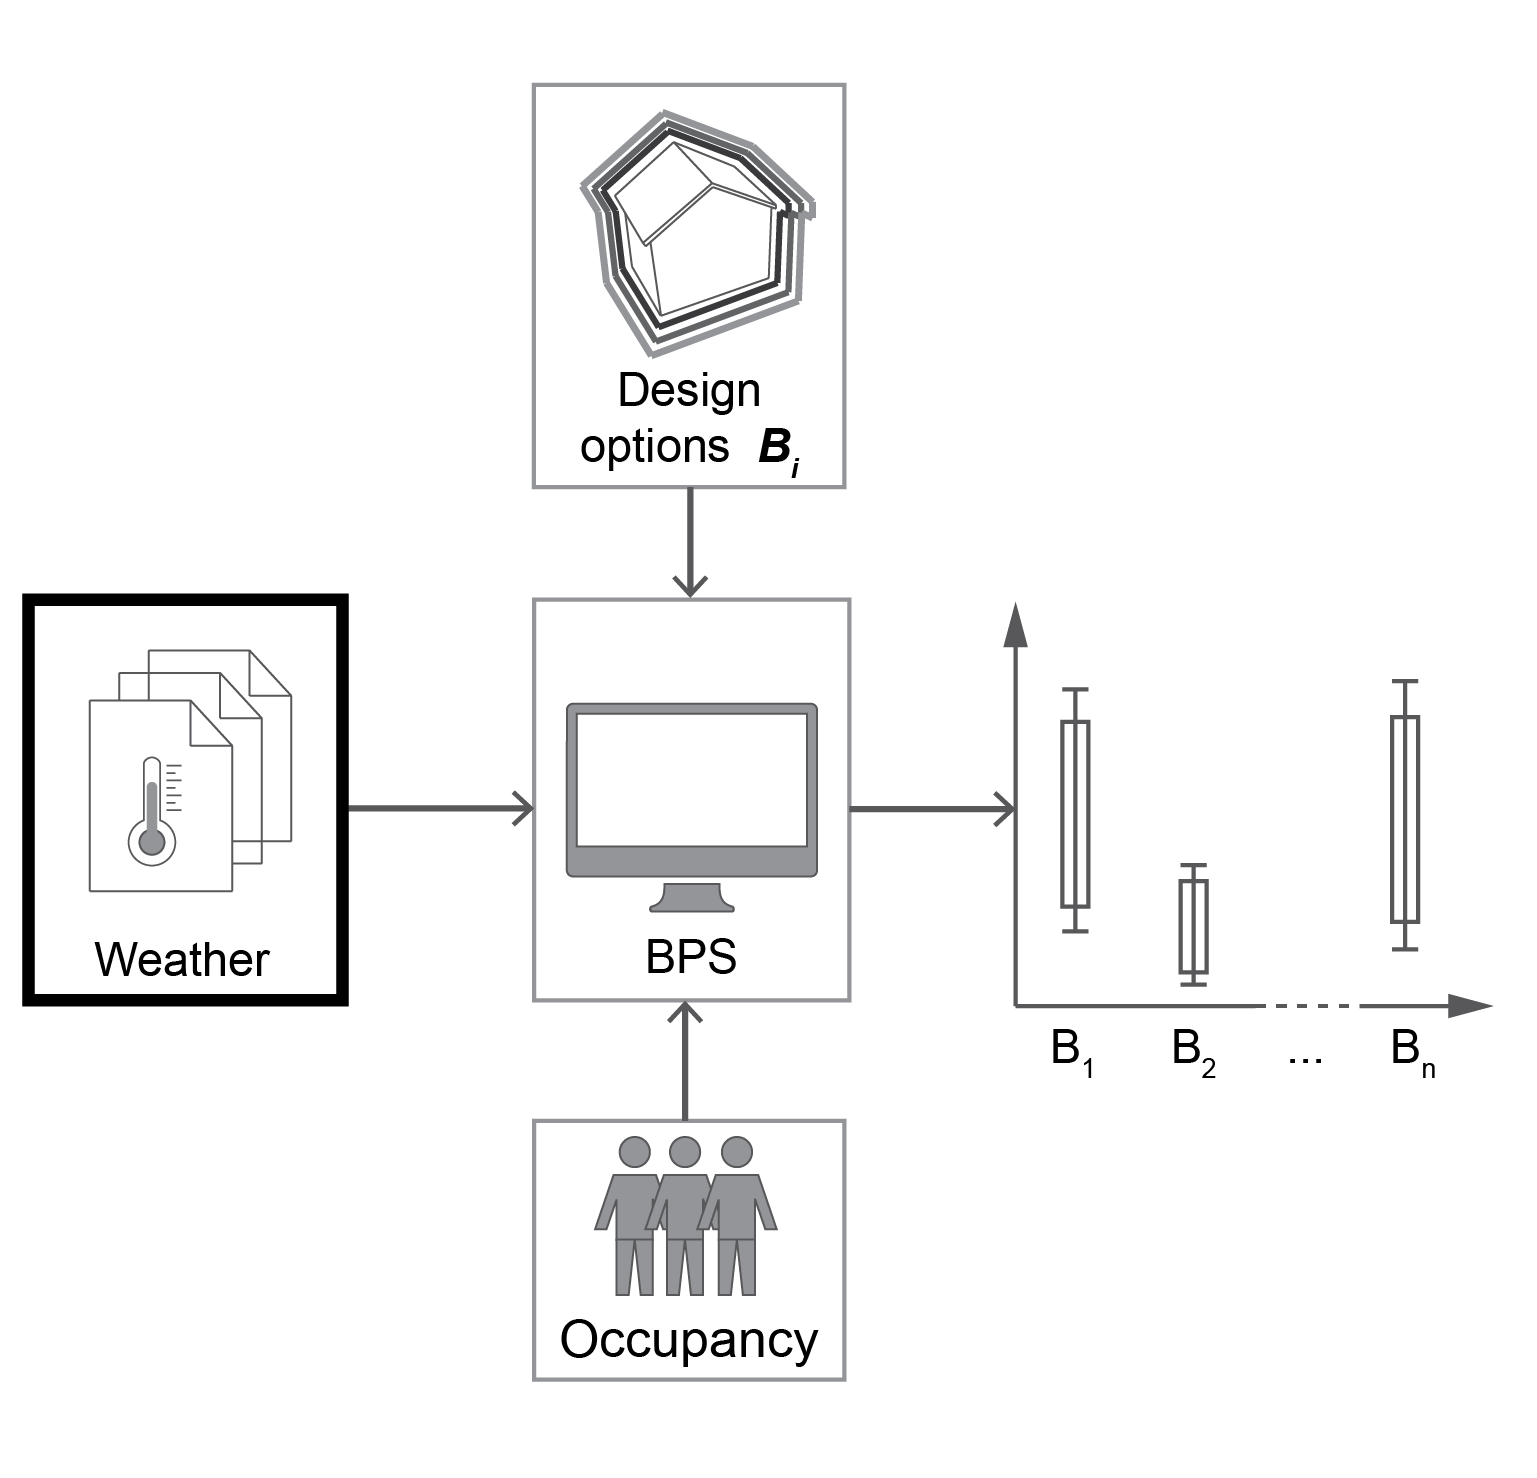

In [2]:
print("Figure 1")
display(Image(filename='../img/MonteCarloSimulation-01.png', width=1000))
print('===========')

*Figure 1*: A schematic of a decision-making process based on multiple simulations. If multiple designs (B_i) are to be evaluated, then it is better to make decisions knowing the full range of possible performance outcomes based on uncertain inputs.

Figure 2


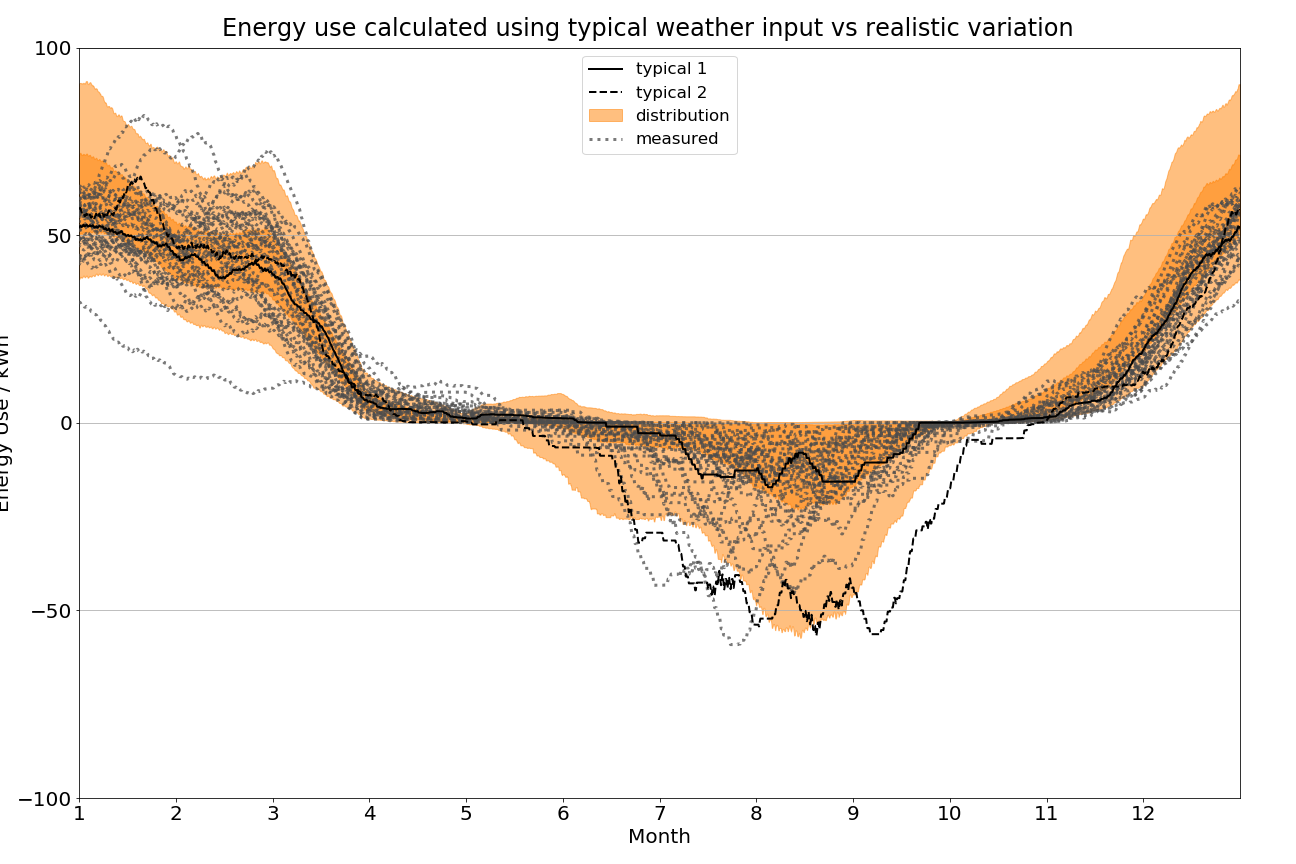

In [3]:
print("Figure 2")
display(Image(filename='../img/y_all_years.png', width=1000))

*Figure 2*: Energy used for space conditioning for an apartment building in Geneva, Switzerland, over one year. Positive energy use means heating is required while negative means cooling is required. Each time series was smoothed with a moving average filter (window=720). The grey lines are for simulations with measured data from 1981 to 2016. Typical 1 and 2 refer to simulation with 'typical' weather data. The distribution is obtained by simulating using
synthetic time series of weather generated by the procedure described in Rastogi and Andersen [2015, 2016], Rastogi [2016]. One can clearly see that simulating with just the typical weather data would not have given any indication of the range of possible heating and cooling energy use values.

<h2>Types of uncertainty and exercises</h2>

The uncertainty in inputs can be separated into two types:

<ol>
    <li> Epistemic - lack of knowledge
    <li> Aleatory - inherent randomness
</ol>

In general, epistemic uncertainty can be reduced with better knowledge but aleatory cannot. Sometimes natural phenomena that appear aleatory, as in, inherently random, may not be so; it could just be that our lack of knowledge about these phenomena makes them seem random. The climate is a good example of this.

<strong>Exercise: Write down two examples of epistemic and aleatory uncertainty related to building simulation, performance, or design.</strong>

============================================================================================================

In this exercise we will use a regression model (black-box model) to estimate the response of a building. We will do an exercise related to epistemic uncertainty and one related to aleatory. The rest of the workshop is structured as follows:

<ol>
    <li> Loading python modules and weather files.
    <li> Black-box models.
    <li> Epistemic uncertainty with black-box models.
    <li> Aleatory uncertainty with black-box models.
</ol>

In [4]:
# Import various standard modules.
import glob
import os
import pickle
import copy
import datetime
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Plotting modules.
import matplotlib.pyplot as plt
# import seaborn as sns

# Get inline graphs .
%matplotlib inline

# Only useful for debugging, when you 
# need to reload external modules.
from importlib import reload

# Enable xkcd mode - if you're a nerd.
# plt.xkcd()

# Import a custom read-write function for weather files.
import wfileio as wf

# import small helpers I've written.
from petites import circ_rolling_mean
from petites import smoother
from petites import dd
from petites import epdf
from petites import rel_hist

# Import an awesome colour palette. Call it colours.
import default_colours as colours

# Set the random seed to a specific value so
# the experiment is repeatable.
# See https://en.wikipedia.org/wiki/Random_seed
# for more information on what this means.
np.random.seed(42)

In [5]:
# Read weather data from location.

# I've used Dehradun as an example here - feel free to download weather data for any other city  
# from http://climate.onebuilding.org/default.html if you like.

# Python can interpret the Unix file separator, the 'forward-slash' (/), on all platforms. 
# That is, if you consistently use '/', the paths are automatically constructed based on the OS.
# If you want to use the Windows back-slash, make sure to precede the path string with an 'r'.
path_epw = '../India_Dehradun/IND_UT_Dehradun.421110_ISHRAE2014.epw'

# The small program get_weather stores data from the incoming weather file as a dataframe. 
# It outputs three things but I'm only using the first output for now, so I've put in underscores
# to indicate that the second and third outputs should not be assigned to a variable in memory.
df_ddn, _, _ = wf.get_weather('ddn', path_epw)

# Do the same with Geneva data. Except Geneva has multiple weather files, so use a loop.
path_folder_gen = '../Switzerland_Geneva/historical'
list_wfiles_gen = glob.glob(path_folder_gen+'/*.epw')

# Declare a list.
list_df_gen = list()

for file in list_wfiles_gen:
    
    gen_temp, _, _ = wf.get_weather('gen', file)
    list_df_gen.append(gen_temp)
    
# Create a dataframe from list but also keep the list - useful for plotting later. 
df_gen = pd.concat(list_df_gen)

print('DEHRADUN')

print(df_ddn.head())

print('======\r\n')

print('GENEVA')

print(df_gen.head())

print('======')

Found multiple years in file name, assigning 2223.
[2002 2003 2005 2006 1996 2001]
Found multiple years in file name, assigning 2223.
[1984 1982 1983 1995 1991 1993 1989 1996 1988]
DEHRADUN
                     year  month  day  hour  minute  \
2223-01-01 00:00:00  2223      1    1     1     0.0   
2223-01-01 01:00:00  2223      1    1     2     0.0   
2223-01-01 02:00:00  2223      1    1     3     0.0   
2223-01-01 03:00:00  2223      1    1     4     0.0   
2223-01-01 04:00:00  2223      1    1     5     0.0   

                                                        qualflags  tdb  tdp  \
2223-01-01 00:00:00  ?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9  6.7  4.7   
2223-01-01 01:00:00  ?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9  6.7  4.2   
2223-01-01 02:00:00  ?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9  6.1  3.7   
2223-01-01 03:00:00  ?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9  6.1  3.8   
2223-01-01 04:00:00  ?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9  5.6  3.3   

    

In [6]:
# Calculate the monthly mean values of weather parameters for Dehradun.

# These are the weather variables that will be used in the regression.
input_vars = ['tdb']

# Each weather parameter is grouped by month, and the monthly mean calculated.
# We only keep the relevant variables (relevant for the energy calculation below, that is.)
ddn_monthly = df_ddn.groupby(by=['month']).mean()[input_vars]
# Assign an index to the dataframe - useful for plotting.    
ddn_monthly.index = pd.unique(df_ddn['month'])

# Do the same for Geneva.
gen_monthly = list()

for yearlong in list_df_gen:
    
    temp_monthly = yearlong.groupby(by=['month']).mean()[input_vars]
    # Assign an index to the dataframe - useful for plotting.    
    temp_monthly.index = pd.unique(yearlong['month'])
    gen_monthly.append(temp_monthly)


c:\program files\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


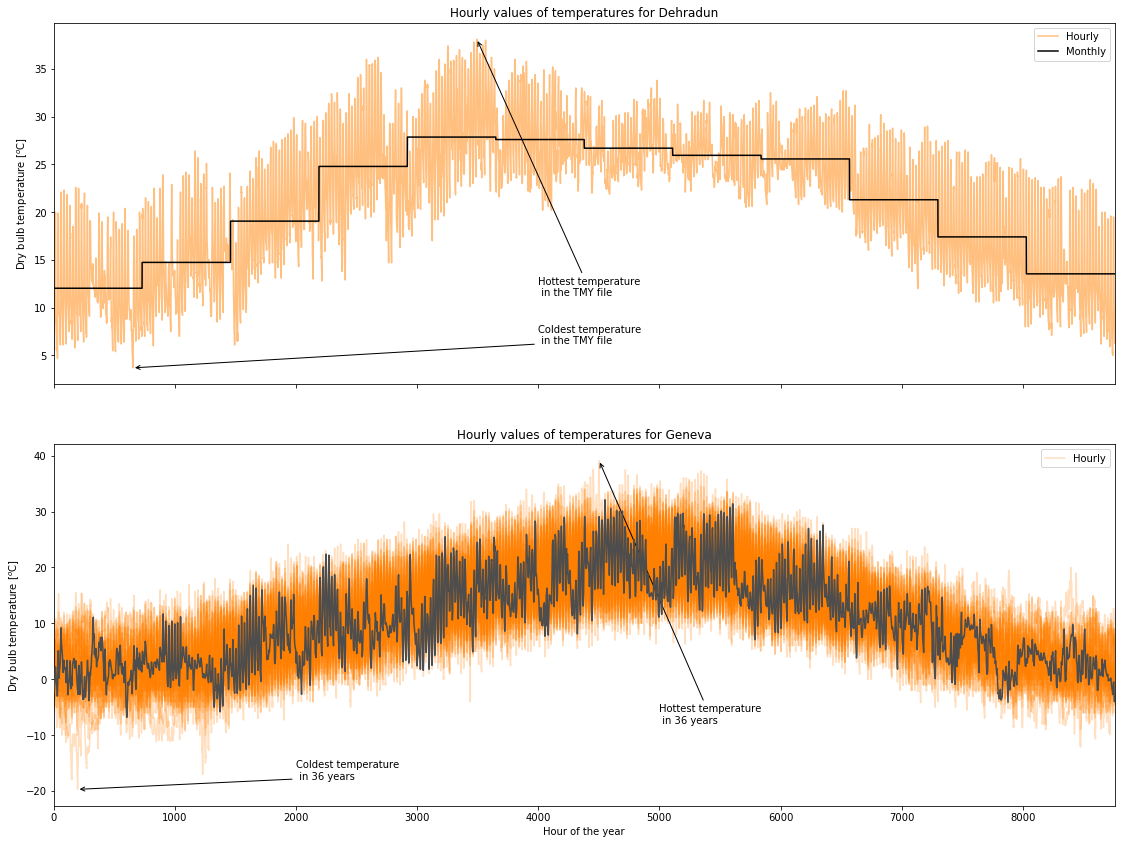

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

# Find the index and value of the max and min temperatures.
ymax = list()
ymin = list()
xmax = list()
xmin = list()

ddn_temp_vals = df_ddn['tdb'].values
ymax.append(np.max(ddn_temp_vals))
xmax.append(np.argmax(ddn_temp_vals))
ymin.append(np.min(ddn_temp_vals))
xmin.append(np.argmin(ddn_temp_vals))

gen_temp_vals = df_gen['tdb'].values
ymax.append(np.max(gen_temp_vals))
ymin.append(np.min(gen_temp_vals))

plot_x = np.arange(0, df_ddn.shape[0])
# ax[0].plot(plot_x, ddn_smooth['tdb'].values, zorder=10, color=colours.blue)
ax[0].plot(plot_x, df_ddn['tdb'].values, zorder = 1, color=colours.orange, alpha=0.5)
ax[0].plot(plot_x, np.repeat(ddn_monthly['tdb'], 8760/12), color=colours.blackest, zorder=11)


for raw, monthly in zip(list_df_gen, gen_monthly):
    
    # ax[1].plot(plot_x, smooth['tdb'], zorder=10, color=colours.blue, alpha=0.75)
    
    raw_temp_vals = raw['tdb'].values
    
    if np.unique(raw.index.year)==2223:
        ax[1].plot(plot_x, raw_temp_vals, zorder = 12, color=colours.grey)
    else:
        ax[1].plot(plot_x, raw_temp_vals, zorder = 1, color=colours.orange, alpha=0.25)
    
    if ymin[1] in raw_temp_vals:
        xmin.append(np.argmin(raw_temp_vals))
    
    if ymax[1] in raw_temp_vals:
        xmax.append(np.argmax(raw_temp_vals))

for ax_temp in ax:
    ax_temp.set_ylabel('Dry bulb temperature [$^o$C]')
    ax_temp.set_xlim(plot_x[0], plot_x[-1])

ax[0].legend(['Hourly', 'Monthly'])
ax[1].legend(['Hourly'])
ax[1].set_xlabel('Hour of the year')
ax[0].set_title('Hourly values of temperatures for Dehradun')
ax[1].set_title('Hourly values of temperatures for Geneva')

ax[0].annotate('Hottest temperature \n in the TMY file\n',
    xy=(xmax[0], ymax[0]), arrowprops=dict(arrowstyle='->'), xytext=(4000, 10))
ax[0].annotate('Coldest temperature \n in the TMY file\n',
    xy=(xmin[0], ymin[0]), arrowprops=dict(arrowstyle='->'), xytext=(4000, 5))

ax[1].annotate('Hottest temperature \n in 36 years\n',
    xy=(xmax[1], ymax[1]), arrowprops=dict(arrowstyle='->'), xytext=(5000, -10))
ax[1].annotate('Coldest temperature \n in 36 years\n',
    xy=(xmin[1], ymin[1]), arrowprops=dict(arrowstyle='->'), xytext=(2000, -20))

plt.show()


<h2> Black Box Models </h2>

A black-box model is any model (mathematical relationship) that can only be viewed in terms of its inputs and outputs. That is, we cannot "see" the inner workings or relationships that result in certain inputs giving certain outputs. It can be used to represent a physical system if sufficient data is available to characterise the relationship between the inputs and outputs of that system. In building simulation, for example, a black-box model could relate outside temperature to heating demand without any indication of how that demand is generated physically, i.e., without solving the equations of heat transfer.  

For this exercise we will use following equation for energy consumption in a given month ($E_m$):

$ E_m = \beta_{0, m} + \beta_{1, m} * \text{HDD}_{m} + \beta_{2, m} * \text{CDD}_{m}$  (1)

where HDD$_m$ is heating degree days in a given month (m), CDD$_m$ is cooling degree days in that same month, $\beta_{1,m}$ and $\beta_{2,m}$ represent the coefficients of each, and $\beta_{0,m}$ represents a constant load or consumption. This equation, thus, relates outdoor environmental conditions to energy usage. The coefficients of each weather/climate term represent the "effect" that that term has on energy usage. The constant (last coefficient) can be thought of as a base load in the context of most buildings, i.e., the part of the load not due to outdoor conditions.

<h2>Exercises</h2>

We will do two exercises, each linked to a different type of uncertainty: 

<ol>
<li> Epistemic uncertainty: fixed inputs, random coefficients. 
<li> Aleatory uncertainty: random inputs, fixed coefficients.
</ol>

In [60]:
# Define a function to calculate monthly energy use using the equation given in Clarke (2001).
# This function takes as input weather data and (optionally) coefficients representing the 
# energy consumption correlated to that weather variable.

def loads_linear(xdata, *beta):
    
    cdd = xdata[0]
    hdd = xdata[1]
    
    if isinstance(beta[0], np.ndarray) or isinstance(beta[0], list):
        beta = beta[0]
                
    e = beta[0] + beta[1]*cdd + beta[2]*hdd
    
    return e

def loads_quad(xdata, *beta):
    
    cdd = xdata[0]
    hdd = xdata[1]
    
    if isinstance(beta[0], np.ndarray) or isinstance(beta[0], list):
        beta = beta[0]
            
    e = beta[0] + beta[1]*cdd + beta[2]*hdd + beta[3]*cdd**2 + beta[4]*hdd**2
    
    return e

<h2>Random coefficients, fixed inputs</h2>

For the first exercise, we fix the inputs to typical values and use random coefficients to specify the relationship between inputs and output. The simulators you use will almost never be random - for buildings at least - so this exercise represents a lack of knowledge about the coefficients. That is to say, <i>if we don't know the relationships, then they appear random</i>.

Every time you run the next cell, it should give you a different set of random coefficients. This in turn means that the values of 'energy consumption' will be different for <i>exactly the same inputs</i>. Clearly, this is not possible for a real building running under the exact same conditions. If you knew the 'answer', i.e., the true energy consumption, you could run this next cell until the coefficients gave you a perfect match of predicted energy use versus measured or true energy use. That is a dumb version of regression modelling, and will show you that pure guesswork, or 'brute force' is often a wasteful means of arriving at an answer. Clever algorithms have been developed that do this faster and with less calculations.

In [9]:
# Select commonly-used balance points for HDD and CDD calculations.
bp= [15, 18] # degrees C

# Let us define a tolerance parameter to remove noise in the calculations.
# This is a common practice - to define a small number below which a value is considered zero.
# If a calculated Cooling or Heating Degree Day monthly sum is less than this number, we will set it to zero.
tol = 3

# You can also put a better filter by setting a cooling and heating 'season'. This can be done by,
# for example, setting CDD and HDD to zero in the respective months.

# Call random coefficients from the generator. Every time you run this, it will give you
# different numbers. Until you restart the kernel, in which case it will give you the same
# series of random numbers as the last time and every time before that.
random_coeffs = np.random.rand(3)

print(random_coeffs)

[0.37454012 0.95071431 0.73199394]


<h3>Random coefficients, Dehradun</h3>

Let's input random coefficients for HDD and CDD in the equation for energy usage in Dehradun. My intuition says to set the coefficient for HDD to zero when calculating cooling load, and vice-versa. <b>Is that correct?</b>

In [10]:
cdd_temp_list = list()
hdd_temp_list = list()
cool_temp_list = list()
heat_temp_list = list()

for m in df_ddn.index.month.unique():
    cdd_temp,hdd_temp = dd(df_ddn.loc[df_ddn.index.month==m,'tdb'], bp, freq='H')
    
    if cdd_temp<=tol:
        cdd_temp = 0
    if hdd_temp<=tol:
        hdd_temp = 0
    
    cdd_temp_list.append(cdd_temp)
    hdd_temp_list.append(hdd_temp)
    
    # Calculate the monthly energy consumption with random coefficients.
    # My intuition says to set the coefficient for HDD to zero when calculating cooling load, and vice-versa.
    # Is that correct?
    cool_temp_list.append(loads_linear([cdd_temp, hdd_temp], [random_coeffs[0], random_coeffs[1], 0]))
    heat_temp_list.append(loads_linear([cdd_temp, hdd_temp], [random_coeffs[0], 0, random_coeffs[2]]))        
    
df_ddn_monthly = pd.DataFrame(
    dict(cdd=cdd_temp_list, hdd=hdd_temp_list, heat_random=heat_temp_list, cool_random=cool_temp_list),
    index=pd.date_range(start='2223-01-01 00:00', end='2223-12-31 23:00', freq='1M'))

Plot the outputs - does the load profile look reasonable? What does the plot of load versus Cooling or Heating Degree Day look like?

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  This is separate from the ipykernel package so we can avoid doing imports until


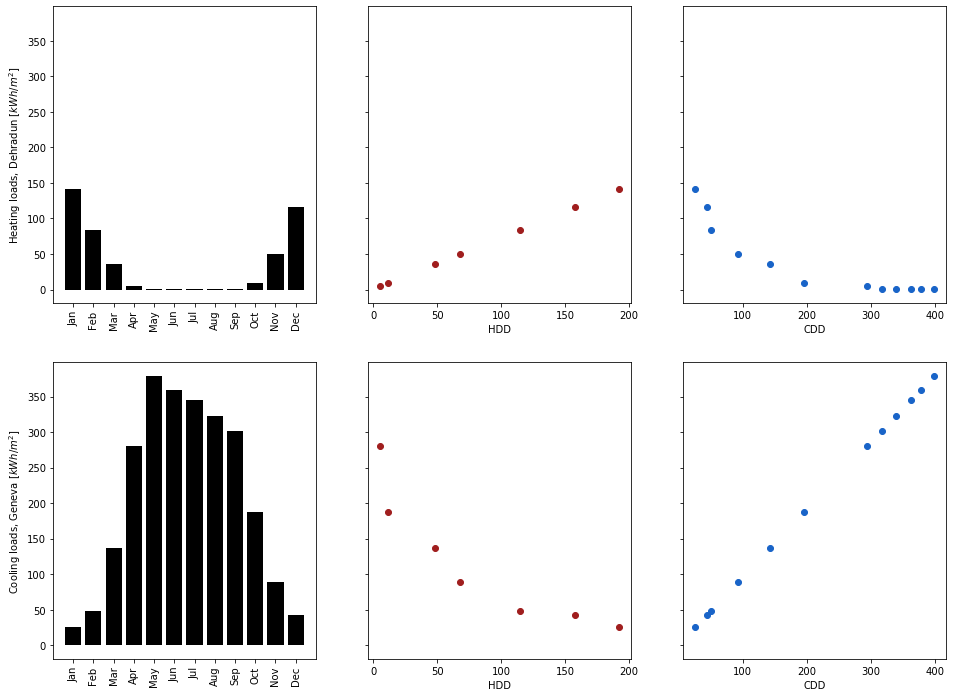

In [11]:
fix, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

fig.suptitle('Random coefficients')

e1 = ax[0].bar(df_ddn_monthly.index.month, df_ddn_monthly.loc[:, 'heat_random'], color=colours.blackest)

h1 = ax[1].plot(df_ddn_monthly.loc[df_ddn_monthly.loc[:, 'hdd']>0, 'hdd'],
                df_ddn_monthly.loc[df_ddn_monthly.loc[:, 'hdd']>0, 'heat_random'],
                marker='o', linewidth = 0, color=colours.red)
c1 = ax[2].plot(df_ddn_monthly.loc[df_ddn_monthly.loc[:, 'cdd']>0, 'cdd'],
                df_ddn_monthly.loc[df_ddn_monthly.loc[:, 'cdd']>0, 'heat_random'],
                marker='o', linewidth = 0, color=colours.blue)

ax[0].set_ylabel('Heating loads, Dehradun [$kWh/m^2$]')

ax[1].set_xlabel('HDD')
ax[2].set_xlabel('CDD')

e1 = ax[3].bar(df_ddn_monthly.index.month, df_ddn_monthly.loc[:, 'cool_random'], color=colours.blackest)

h1 = ax[4].plot(df_ddn_monthly.loc[df_ddn_monthly.loc[:, 'hdd']>0, 'hdd'],
                df_ddn_monthly.loc[df_ddn_monthly.loc[:, 'hdd']>0, 'cool_random'],
                marker='o', linewidth = 0, color=colours.red)
c1 = ax[5].plot(df_ddn_monthly.loc[df_ddn_monthly.loc[:, 'cdd']>0, 'cdd'],
                df_ddn_monthly.loc[df_ddn_monthly.loc[:, 'cdd']>0, 'cool_random'],
                marker='o', linewidth = 0, color=colours.blue)

ax[3].set_ylabel('Cooling loads, Geneva [$kWh/m^2$]')
ax[4].set_xlabel('HDD')
ax[5].set_xlabel('CDD')

# ax[0].set_ylim([0, 300])

ax[0].set_xticks(np.arange(1,13,1))
ax[0].set_xticklabels([x[:3] for x in df_ddn_monthly.index.month_name()], rotation=90)
ax[3].set_xticks(np.arange(1,13,1))
ax[3].set_xticklabels([x[:3] for x in df_ddn_monthly.index.month_name()], rotation=90)

plt.show()

<h3> Questions</h3>
<ul>
    <li> Is the profile of loads broadly correct? </li>
    <li> Why do some of the plots look linear? </li>    
</ul>

<h3> Random coefficients, Geneva</h3>

Let's plot again with data from Geneva. Then, we can compare the model outputs with results from actual simulations, to show why this approach is rubbish.

In [12]:
cdd_temp_list = list()
hdd_temp_list = list()
index_temp_list = list()
cool_temp_list = list()
heat_temp_list = list()

for y in df_gen.index.year.unique():
    for m in df_gen.index.month.unique():
        
        time_filter = np.logical_and(df_gen.index.year==y, df_gen.index.month==m)
        
        cdd_temp, hdd_temp = dd(df_gen.loc[time_filter,'tdb'],
                         bp, freq='H')
        
        if cdd_temp<=tol:
            cdd_temp = 0
        if hdd_temp<=tol:
            hdd_temp = 0
    
        index_temp = pd.to_datetime(f'{y}-{m}-01 00:00')
        
        cdd_temp_list.append(cdd_temp)
        hdd_temp_list.append(hdd_temp)
        index_temp_list.append(index_temp)
    
        # Calculate the monthly energy consumption with random coefficients.
        cool_temp_list.append(loads_linear([cdd_temp, hdd_temp], [random_coeffs[0], random_coeffs[1], 0]))
        heat_temp_list.append(loads_linear([cdd_temp, hdd_temp], [random_coeffs[0], 0, random_coeffs[2]]))        
     
df_gen_monthly = pd.DataFrame(dict(cdd=cdd_temp_list, hdd=hdd_temp_list, heat_random=heat_temp_list, cool_random=cool_temp_list),index=index_temp_list)

# Sort dataframe by year.
df_gen_monthly.sort_index(inplace=True)

In [13]:
# Load simulation results.
loads_hourly = pickle.load(open('../Switzerland_Geneva/total_hourly_loads.p', 'rb'))

# The typical years in this data are tagged with the year 1900 but the weather data uses year 2223,
# because the datasets are based on different versions of my code.
# Anyhow, we drop the typical data for the fitting step.
loads_hourly.drop(loads_hourly[loads_hourly.index.year==1900].index, inplace=True)
loads_hourly.sort_index(inplace=True)

loads_monthly = loads_hourly.groupby([loads_hourly.index.year, loads_hourly.index.month]).sum()
loads_monthly.index = df_gen_monthly[df_gen_monthly.index.year!=2223].index


            Heating       Cooling
count  3.066000e+05  3.066000e+05
mean   5.143014e+07  9.886836e+06
std    9.333473e+07  7.517499e+07
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00
75%    6.568471e+07  0.000000e+00
max    7.526488e+08  1.253849e+09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ED0A850B00>,
      dtype=object)

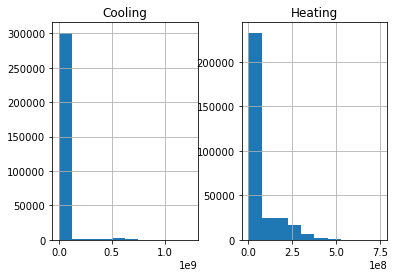

In [30]:
# Quick inspection of uploaded data.
print(loads_hourly.describe())
loads_hourly.hist()

            Heating       Cooling
count  4.200000e+02  4.200000e+02
mean   3.754400e+10  7.217390e+09
std    5.350808e+10  1.738010e+10
min    1.527179e-10  0.000000e+00
25%    2.544491e+07  3.231048e-11
50%    5.915820e+09  2.276628e+04
75%    6.621772e+10  3.467446e+09
max    2.019751e+11  1.393221e+11


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ED0AE05438>,
      dtype=object)

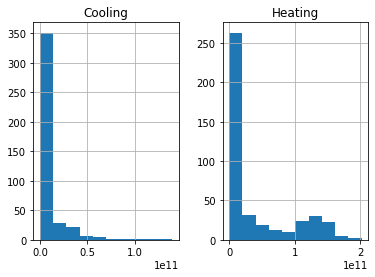

In [32]:
# Does monthly data make sense?
print(loads_monthly.describe())
loads_monthly.hist()

In [ ]:
# Drop typical years from df_gen_monthly dataframe
df_gen_monthly.drop(df_gen_monthly[df_gen_monthly.index.year==2223].index, inplace=True)

# Add simulated loads (loads_monthly), converting them from J/m2 to kWh/m2.
df_gen_monthly = pd.concat([df_gen_monthly,pd.DataFrame(dict(heat_sim=loads_monthly['Heating']/(3.6e6),
         cool_sim=loads_monthly['Cooling']/(3.6e6)))], sort=True, axis=1)

# # Calculate error between simulated loads (ground truth) and loads calculated with random inputs.
df_gen_monthly.loc[:,'heat_error_random'] = df_gen_monthly.loc[:,'heat_sim']-df_gen_monthly.loc[:,'heat_random']
df_gen_monthly.loc[:,'cool_error_random'] = df_gen_monthly.loc[:,'cool_sim']-df_gen_monthly.loc[:,'cool_random']

In [14]:
# Calculate error histograms for plotting later

hist_err = dict(heating=None, cooling=None)

bins_random = np.arange(0, 1000, 50)
hist_err['heat_random'], _ = epdf(df_gen_monthly['heat_error_random'].values, bins=bins_random)
hist_err['cool_random'],_ = epdf(df_gen_monthly['cool_error_random'].values, bins=bins_random)

hist_err = pd.DataFrame(hist_err)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  This is separate from the ipykernel package so we can avoid doing imports until


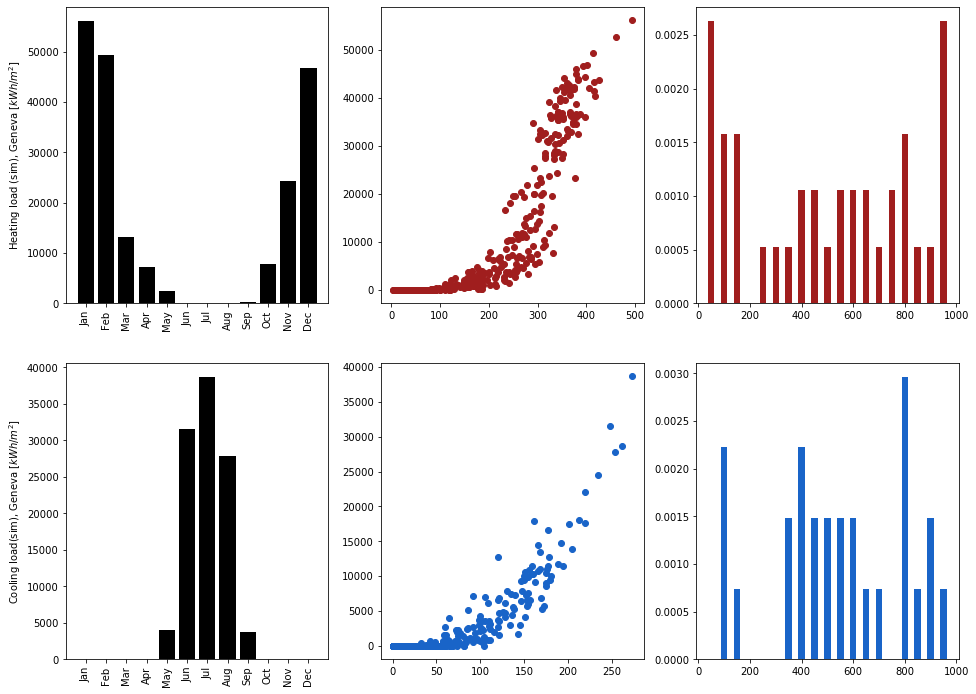

In [15]:
fix, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

ax[0].set_ylabel('Heating load (sim), Geneva [$kWh/m^2$]')
e1 = ax[0].bar(df_gen_monthly.index.month, df_gen_monthly.loc[:, 'heat_sim'], color=colours.blackest)

h1 = ax[1].plot(df_gen_monthly.loc[:, 'heat_random'],
                df_gen_monthly.loc[:, 'heat_sim'],
                marker='o', linewidth = 0, color=colours.red)
c1 = ax[2].bar(bins_random[1:], hist_err.loc[:, 'heat_random'], width=25, color=colours.red)

ax[3].set_ylabel('Cooling load(sim), Geneva [$kWh/m^2$]')
e1 = ax[3].bar(df_gen_monthly.index.month, df_gen_monthly.loc[:, 'cool_sim'], color=colours.blackest)

h1 = ax[4].plot(df_gen_monthly.loc[:, 'cool_random'],
                df_gen_monthly.loc[:, 'cool_sim'],
                marker='o', linewidth = 0, color=colours.blue)
c1 = ax[5].bar(bins_random[1:], hist_err.loc[:, 'cool_random'], width=25, color=colours.blue)

ax[0].set_xticks(np.arange(1,13,1))
ax[0].set_xticklabels([x[:3] for x in df_gen_monthly.index.month_name()], rotation=90)
ax[3].set_xticks(np.arange(1,13,1))
ax[3].set_xticklabels([x[:3] for x in df_gen_monthly.index.month_name()], rotation=90)

plt.show()

<h2>Sensible coefficients, fixed inputs</h2>

Repeat the above exercise with more meaningful coefficients for the various weather parameters. We will use optimisation to fit the equation to the following simulation data. What kind of relationship do you expect to see between the degree days and loads?

In [33]:
# Normalise all input and output values first.
# Ask me about why this step is important.
   
xymeans = df_gen_monthly.mean()
xystdevs = df_gen_monthly.std()

df_scaled_gen = (df_gen_monthly - xymeans) / xystdevs

# This should give us zero means and unit variance/stdev.
print(df_scaled_gen.describe())

popt = dict(heat=None, cool=None)
pcov = dict(heat=None, cool=None)

# Call a curve_fit function.
popt['heat'], pcov['heat'] = curve_fit(loads_linear, 
                       [df_scaled_gen.loc[:, 'cdd'].values, df_scaled_gen.loc[:, 'hdd'].values], 
                       df_scaled_gen.loc[:,'heat_sim'].values,
                       p0=np.zeros(3))
popt['cool'], pcov['cool'] = curve_fit(loads_linear, 
                       [df_scaled_gen.loc[:, 'cdd'].values, df_scaled_gen.loc[:, 'hdd'].values], 
                       df_scaled_gen.loc[:,'cool_sim'].values,
                       p0=np.zeros(3).tolist())

                cdd           hdd   heat_random   cool_random      heat_sim  \
count  4.200000e+02  4.200000e+02  4.200000e+02  4.200000e+02  4.200000e+02   
mean  -8.458842e-17  1.987828e-16 -1.945534e-16 -6.597897e-16 -3.425831e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -7.419276e-01 -1.410263e+00 -1.410263e+00 -7.419276e-01 -7.016510e-01   
25%   -7.419276e-01 -9.770684e-01 -9.770684e-01 -7.419276e-01 -7.011755e-01   
50%   -5.694738e-01 -9.530377e-02 -9.530377e-02 -5.694738e-01 -5.910917e-01   
75%    5.602760e-01  9.192010e-01  9.192010e-01  5.602760e-01  5.358765e-01   
max    3.625905e+00  2.437287e+00  2.437287e+00  3.625905e+00  3.073015e+00   

           cool_sim  heat_error_random  cool_error_random      heat_fit  \
count  4.200000e+02       4.200000e+02       4.200000e+02  4.200000e+02   
mean  -4.652363e-16      -4.356304e-16      -2.453064e-16  6.005778e-16   
std    1.000000e+00       1.000000e+00       1.000000e+00  1.00

In [17]:
# Calculate the monthly energy consumption with 'optimised' coefficients.

df_scaled_gen.loc[:,'heat_fit'] = loads_linear(
    [df_scaled_gen.loc[:,'cdd'].values, df_scaled_gen.loc[:,'hdd']], popt['heat'].tolist())
df_scaled_gen.loc[:,'cool_fit'] = loads_linear(
    [df_scaled_gen.loc[:,'cdd'].values, df_scaled_gen.loc[:,'hdd']], popt['cool'].tolist())

# Use the mean and stdev of the original y data to rescale the calculated loads.
xymeans['heat_fit'] = xymeans['heat_sim']
xystdevs['heat_fit'] = xystdevs['heat_sim']
xymeans['cool_fit'] = xymeans['cool_sim']
xystdevs['cool_fit'] = xystdevs['cool_sim']

df_gen_monthly.loc[:,'heat_fit'] = (df_scaled_gen.loc[:,'heat_fit'] * xystdevs['heat_fit']) + xymeans['heat_fit']
df_gen_monthly.loc[:,'cool_fit'] = (df_scaled_gen.loc[:,'cool_fit'] * xystdevs['cool_fit']) + xymeans['cool_fit']

df_gen_monthly.loc[df_gen_monthly.loc[:,'heat_fit']<0,'heat_fit'] = 0
df_gen_monthly.loc[df_gen_monthly.loc[:,'cool_fit']<0,'cool_fit'] = 0

df_gen_monthly.loc[:,'heat_error_fit'] = df_gen_monthly.loc[:,'heat_sim'] - df_gen_monthly.loc[:,'heat_fit']
df_gen_monthly.loc[:,'cool_error_fit'] = df_gen_monthly.loc[:,'cool_sim'] - df_gen_monthly.loc[:,'cool_fit']


In [18]:
# Calculate error histograms for plotting later

hist_err = pd.DataFrame()

bins_fit = np.arange(-10000,10500,500)

hist_err.loc[:,'heat_fit'],_ = rel_hist(np.clip(df_gen_monthly['heat_error_fit'], bins_fit[0], bins_fit[-1]),bins=bins_fit)
hist_err.loc[:,'cool_fit'],_ = rel_hist(np.clip(df_gen_monthly['cool_error_fit'], bins_fit[0], bins_fit[-1]),bins=bins_fit)

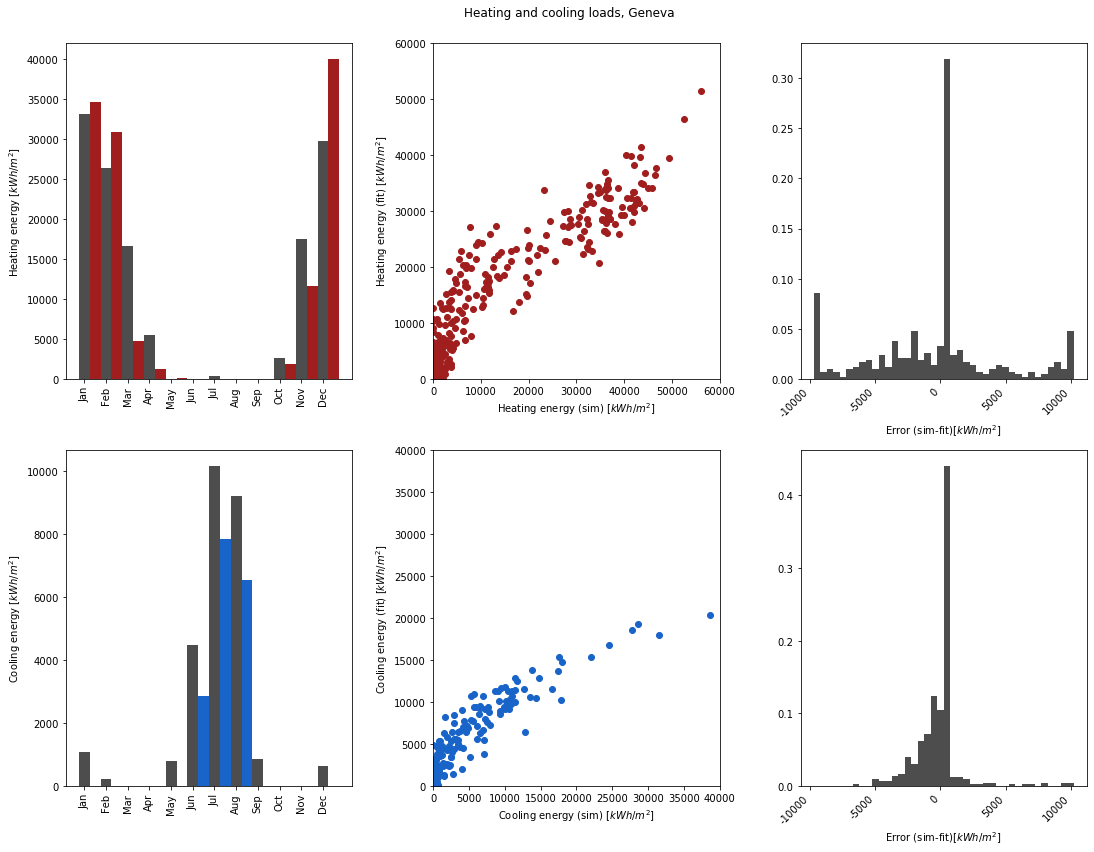

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=5, w_pad=5, h_pad=5)

fig.suptitle('Heating and cooling loads, Geneva')

width=0.5

ax[0].bar(df_gen_monthly.index.month.unique(),
          df_gen_monthly.loc[:,'heat_fit'].groupby(by=df_gen_monthly.index.month).median(),
          alpha=1, zorder=101, color=colours.grey, width=width)
ax[0].bar(df_gen_monthly.index.month.unique()+width,
          df_gen_monthly.loc[:,'heat_sim'].groupby(by=df_gen_monthly.index.month).median(),
          alpha=1, zorder=100, color=colours.red, width=width)
ax[1].plot(df_gen_monthly.loc[:,'heat_sim'], df_gen_monthly.loc[:,'heat_fit'],
           linewidth=0, marker='o', color=colours.red)
ax[2].bar(bins_fit[1:], hist_err.loc[:, 'heat_fit'],
         width=500, color=colours.grey)

ax[3].bar(df_gen_monthly.index.month.unique(),
          df_gen_monthly.loc[:,'cool_fit'].groupby(by=df_gen_monthly.index.month).median(),
          alpha=1, zorder=101, color=colours.grey, width=width)
ax[3].bar(df_gen_monthly.index.month.unique()+width,
          df_gen_monthly.loc[:,'cool_sim'].groupby(by=df_gen_monthly.index.month).median(),
          alpha=1, zorder=100, color=colours.blue, width=width)
ax[4].plot(df_gen_monthly.loc[:,'cool_sim'], df_gen_monthly.loc[:,'cool_fit'],
           linewidth=0, marker='o', color=colours.blue)
ax[5].bar(bins_fit[1:], hist_err.loc[:, 'cool_fit'],
         width=500, color=colours.grey)

ax[0].set_ylabel('Heating energy [$kWh/m^2$]')
ax[0].set_xticks(np.arange(1,13))
ax[0].set_xticklabels([x[:3] for x in df_gen_monthly.index.month_name()], rotation=90)
ax[1].set_ylabel('Heating energy (fit) [$kWh/m^2$]')
ax[1].set_xlabel('Heating energy (sim) [$kWh/m^2$]')
ax[2].set_xlabel('Error (sim-fit)[$kWh/m^2$]')
ax[1].set_xlim([0,60000])
ax[1].set_ylim([0,60000])
ax[2].set_xticks(np.append(bins_fit[0:-1:10], bins_fit[-1]))
ax[2].set_xticklabels(np.append(bins_fit[0:-1:10], bins_fit[-1]), rotation = 45, ha="right")

ax[3].set_ylabel('Cooling energy [$kWh/m^2$]')
ax[3].set_xticks(np.arange(1,13))
ax[3].set_xticklabels([x[:3] for x in df_gen_monthly.index.month_name()], rotation=90)
ax[4].set_ylabel('Cooling energy (fit) [$kWh/m^2$]')
ax[4].set_xlabel('Cooling energy (sim) [$kWh/m^2$]')
ax[5].set_xlabel('Error (sim-fit)[$kWh/m^2$]')
ax[4].set_xlim([0,40000])
ax[4].set_ylim([0,40000])
ax[5].set_xticks(np.append(bins_fit[0:-1:10], bins_fit[-1]))
ax[5].set_xticklabels(np.append(bins_fit[0:-1:10], bins_fit[-1]), rotation = 45, ha="right")

plt.show()

## Fixed coefficients, random inputs

Now let's try the same exercise with fixed coefficients and random inputs.


In [20]:
# Load the synthetic future time series.
path_to_syn = '../Switzerland_Geneva/synthetic/syn_2051_2060_red.p'
synlist = pickle.load(open(path_to_syn, 'rb'))

syndata = pd.concat(synlist)

In [21]:
# Number of years in dataset.
future_years = list()

for df in synlist:
    future_years.extend((df['year'].unique().tolist()))

n_years = (np.unique(future_years)).size
n_hours = 8760  # Fixed for this dataset.

In [94]:
temp = syndata.loc[:,'tdb'].groupby(
    [syndata.index.year, syndata.index.month]).apply(lambda x: dd(x, bp, freq='H'))

df_syn_monthly = pd.DataFrame(temp.values.tolist(), columns=['cdd','hdd'],
                              index=pd.date_range(start='2051-01-31', end='2060-12-31', freq='1M'))

df_syn_monthly.loc[:, 'tdb'] = syndata.loc[:, 'tdb'].groupby(
    [syndata.index.year, syndata.index.month]).mean()

TypeError: incompatible index of inserted column with frame index

In [93]:
syndata.loc[:,'tdb']

2051-01-01 00:00:00     1.284387
2051-01-01 01:00:00     1.046227
2051-01-01 02:00:00    -0.318254
2051-01-01 03:00:00    -0.813486
2051-01-01 04:00:00    -0.601870
                         ...    
2060-12-31 19:00:00    18.949945
2060-12-31 20:00:00    18.949945
2060-12-31 21:00:00    18.949945
2060-12-31 22:00:00    18.949945
2060-12-31 23:00:00    18.949945
Name: tdb, Length: 14016000, dtype: float64

In [78]:
# Now let's fix the coefficients to some 'known' values (from the linear fit above)
# and plot the outputs using 'random' inputs.

# xymeans_syn = df_syn_monthly.mean()
# xystdevs_syn = df_syn_monthly.std()

df_syn_scaled = (df_syn_monthly - df_syn_monthly.mean()) / df_syn_monthly.std()
   
df_syn_scaled['heat_fit'] = loads_linear(
    [df_syn_scaled.loc[:,'cdd'], df_syn_scaled.loc[:,'hdd']], popt['heat'].tolist())
df_syn_scaled['cool_fit'] = loads_linear(
    [df_syn_scaled.loc[:,'cdd'].values, df_syn_scaled.loc[:,'hdd']], popt['cool'].tolist())

# # xymeans_syn['energy_fit'] = xymeans['energy_fit']
# # xystdevs_syn['energy_fit'] = xystdevs['energy_fit']

df_syn_monthly['heat_fit'] = (df_syn_scaled['heat_fit'] * xystdevs['heat_fit']) + xymeans['heat_fit']
df_syn_monthly['cool_fit'] = (df_syn_scaled['cool_fit'] * xystdevs['cool_fit']) + xymeans['cool_fit']

2051-01-31   -0.628966
2051-02-28    0.169885
2051-03-31   -0.940446
2051-04-30    0.530117
2051-05-31    0.583211
2051-06-30   -0.303350
2051-07-31    0.416494
2051-08-31    0.499160
2051-09-30    0.718688
2051-10-31    0.697105
Freq: M, Name: hdd, dtype: float64
2051-01-31    0.878895
2051-02-28   -0.135767
2051-03-31    1.850080
2051-04-30    0.170275
2051-05-31    0.059297
2051-06-30    0.973840
2051-07-31   -0.393761
2051-08-31   -0.780184
2051-09-30   -0.610122
2051-10-31   -1.171934
Freq: M, Name: cdd, dtype: float64
2051-01-31   -0.343962
2051-02-28    0.147256
2051-03-31   -0.227664
2051-04-30    0.777164
2051-05-31    0.786524
2051-06-30    0.128240
2051-07-31    0.328442
2051-08-31    0.228758
2051-09-30    0.603833
2051-10-31    0.275421
Freq: M, dtype: float64
2051-01-31   -0.628966
2051-02-28    0.169885
2051-03-31   -0.940446
2051-04-30    0.530117
2051-05-31    0.583211
2051-06-30   -0.303350
2051-07-31    0.416494
2051-08-31    0.499160
2051-09-30    0.718688
2051-10-3

In [87]:
df_syn

,cdd,hdd
2051-01-31,6122.857129,34827.559533
2051-02-28,3912.200840,41450.937070
2051-03-31,8238.789534,32245.029240
2051-04-30,4578.979191,44437.677610
2051-05-31,4337.189271,44877.885039
...,...,...
2060-08-31,1826.913911,17679.073129
2060-09-30,2987.925457,18993.700385
2060-10-31,1521.758981,20463.749876
2060-11-30,1156.741343,23792.238584


In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

ax[0].set_title('Monthly energy usage, Geneva [$kWh/m^2$]')
ax[1].set_title('Future temperature, Geneva [$\circ$C]')

# plot_x = range(0, syn_summary.shape[0])

ax[0].plot(df_syn_monthly.loc[:,'heat_fit'], alpha=1, zorder=103, color=colours.red)
ax[0].plot(df_syn_monthly.loc[:,'cool_fit'], alpha=1, zorder=104, color=colours.blue)

ax[1].plot(syndata.loc[:,'tdb'], alpha=1, zorder=103, color=colours.blackest)
# ax[0].set_xlim(plot_x[0], plot_x[-1])

# ax[1].plot(syn_summary.index.month, syn_summary['tdb'], linewidth=0, marker='o')

ax[0].set_ylabel('Energy / [kWh]')
ax[1].set_ylabel('Temperature / [$\circ$C]')

plt.show()

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 1152x864 with 4 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,6])
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

ax[0].plot(syn_summary['tdb'], syn_summary['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[0].set_ylabel('Energy [kWh]')
ax[0].set_xlabel('Temperature [$^o$C]')
ax[0].set_title('Energy use vs Temperature')

ax[1].plot(syn_summary['wspd'], syn_summary['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[1].set_ylabel('Energy [kWh]')
ax[1].set_xlabel('Wind speed [m/s]')
ax[1].set_title('Energy use vs Wind speed')

ax[2].plot(syn_summary['ghi'], syn_summary['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[2].set_ylabel('Energy [kWh]')
ax[2].set_xlabel('GHI [$kWh/m^2$]')
ax[2].set_title('Energy use vs GHI')

ax[3].plot(syn_summary['dni'], syn_summary['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[3].set_ylabel('Energy [kWh]')
ax[3].set_xlabel('DNI [$kWh/m^2$]')
ax[3].set_title('Energy use vs DNI')

plt.show()

## Uncertainty analysis with EPlus

### Steps/Notes

1. Consider weather inputs from Indra.
2. Run samples using EPlus - analyse results.
    1. Either modify a base EPlus file using Eppy/scripting or in jePlus.
    2. Or analyse the same EPlus file using many weather files.

<h2> Bibliography </h2>

<ul>
<li>Rastogi, Parag. 2016. “On the Sensitivity of Buildings to Climate: The Interaction of Weather and Building Envelopes in Determining Future Building Energy Consumption.” PhD, Lausanne, Switzerland: Ecole polytechnique fédérale de Lausanne. EPFL Infoscience. https://infoscience.epfl.ch/record/220971?ln=en.
<li>Rastogi, Parag, and Marilyne Andersen. 2015. “Embedding Stochasticity in Building Simulation Through Synthetic Weather Files.” In Proceedings of BS 2015. Hyderabad, India. http://infoscience.epfl.ch/record/208743.
<li>———. 2016. “Incorporating Climate Change Predictions in the Analysis of Weather-Based Uncertainty.” In Proceedings of SimBuild 2016. Salt Lake City, UT, USA. http://infoscience.epfl.ch/record/208743.
<li>Rastogi, Parag, Mohammad Emtiyaz Khan, and Marilyne Andersen. 2017. “Gaussian-Process-Based Emulators for Building Performance Simulation.” In Proceedings of BS 2017. San Francisco, CA, USA: IBPSA.
<li>Iaccarino, Gianluca. 2008. “Quantification of Uncertainty in Flow Simulations Using Probabilistic Methods.” presented at the VKI Lecture Series, Stanford University, September. http://web.stanford.edu/group/uq/uq_youq.html.
<li>Macdonald, Iain. 2002. “Quantifying the Effects of Uncertainty in Building Simulation.” Doctoral, University of Strathclyde. https://www.strath.ac.uk/media/departments/mechanicalengineering/esru/research/phdmphilprojects/macdonald_thesis.pdf.

</ul>